# **Project:** Home Credit Default Risk

## Team Members: Victoria (Xinyue) Shi, Yanchen (Kathryn) Zhou

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Overview
Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

[Home Credit Group](https:/http://www.homecredit.net/) strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

Kaggle Compeition and Dataset Link: https://www.kaggle.com/competitions/home-credit-default-risk/overview


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Load Training data

In [ ]:
app_train = pd.read_csv('/content/gdrive/MyDrive/input/application_train.csv')
print(app_train.shape)
app_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


The training data has 307511 rows and 122 features including the TARGET.

## **Exploratory Data Analysis**

### Target Value distribution

In the Home Credit Default Risk application_test dataset, the TARGET column indicates whether a loan was repaid (0) or not (1).

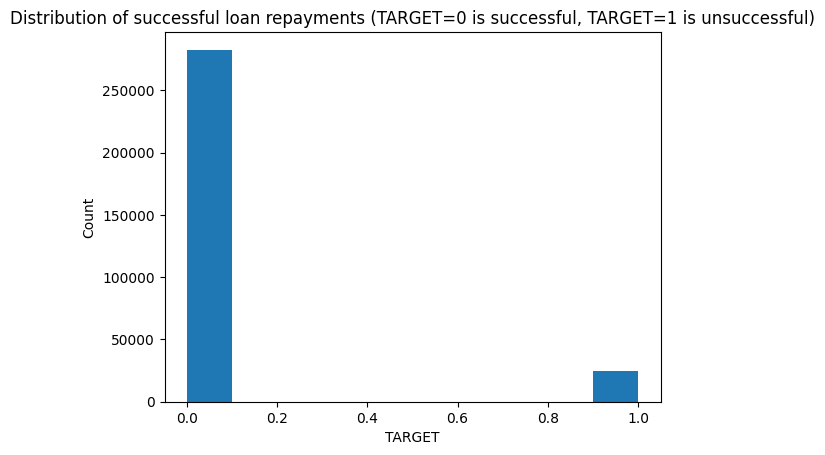

In [ ]:
plt.hist(app_train['TARGET'].astype(int))
plt.title('Distribution of successful loan repayments (TARGET=0 is successful, TARGET=1 is unsuccessful)')
plt.xlabel('TARGET')
plt.ylabel('Count')
plt.show()

In [ ]:
target_distribution = app_train['TARGET'].value_counts()
target_distribution

TARGET
0    282686
1     24825
Name: count, dtype: int64

From the graph above, we can see that that there are 282686 cases in which loan was repaid (TARGET=0) and 24825 cases in which the loan was not repaid (TARGET=1).
This means that the dataset is imbalance with over 90% of successful loan repayments. This can potentially impact the performance of machine learning models with more bias towards predicting the majority class.

### Missing values

In [ ]:
import pandas as pd

def missing_values(df):
    missing_values = df.isnull().sum()
    missing_values_percentage = 100 * df.isnull().sum() / len(df)

    table = pd.concat([missing_values, missing_values_percentage], axis=1)

    newtable = table.rename(columns = {0 : 'Total Count of Missing Values', 1 : '% of Total Values are Missing'})

    newtable = newtable[newtable.iloc[:,1] != 0].sort_values('% of Total Values are Missing', ascending=False)

    print(f"{str(newtable.shape[0])} columns out of the total {str(df.shape[1])} features have missing values.")

    return newtable

In [ ]:
missing_values_table = missing_values(app_train)
missing_values_table.head()

67 columns out of the total 122 features have missing values.


,Total Count of Missing Values,% of Total Values are Missing
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963


### Input Feature Datatypes

In [ ]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

65 input features are of type float, 41 are of type int, and 16 are of type object (strings and categorical features).

In [ ]:
unique_counts = pd.Series([app_train[col].nunique() for col in app_train.select_dtypes('object').columns])

These are all the features of object type. To make binary predictions in this case, we need to encode these features into numbers. We used label encoding.

In [ ]:
# Label Encoding
le = LabelEncoder()
for col in app_train:
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2:
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col])

# One-hot Encoding
app_train = pd.get_dummies(app_train)

print('Training Features shape: ', app_train.shape)

Training Features shape:  (307511, 243)


In [ ]:
null_values = app_train.isnull().sum()

# Filter out columns with null values
columns_with_null = null_values[null_values > 0]

# Display columns with null values and their corresponding count
print("Columns with Null Values:")
print(columns_with_null)

Columns with Null Values:
AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
OWN_CAR_AGE                   202929
CNT_FAM_MEMBERS                    2
EXT_SOURCE_1                  173378
                               ...  
AMT_REQ_CREDIT_BUREAU_DAY      41519
AMT_REQ_CREDIT_BUREAU_WEEK     41519
AMT_REQ_CREDIT_BUREAU_MON      41519
AMT_REQ_CREDIT_BUREAU_QRT      41519
AMT_REQ_CREDIT_BUREAU_YEAR     41519
Length: 61, dtype: int64


### Input Feature Value Distribution

In [ ]:
for x in ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE']:
    if x != 'OWN_CAR_AGE':
        print((app_train[x] / -365).describe()) # to convert to number of years
        app_train[x] = app_train[x] / -365
    else:
        print(app_train[x].describe())

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64
count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64
count    307511.000000
mean         13.660604
std           9.651743
min          -0.000000
25%           5.506849
50%          12.339726
75%          20.491781
max          67.594521
Name: DAYS_REGISTRATION, dtype: float64
count    307511.000000
mean          8.203294
std           4.135481
min          -0.000000
25%           4.712329
50%           8.915068
75%          11.778082
max          19.717808
Name: DAYS_ID_PUBLISH, dtype: float64
count    104582.000000
mean         12.061091
std          11.944812
min           0.000000
25%           5.000000
50

In [ ]:
app_train.shape

(307511, 243)

## Data Profiling

In [ ]:
app_train_categorical = pd.read_csv('/content/gdrive/MyDrive/input/application_train.csv')

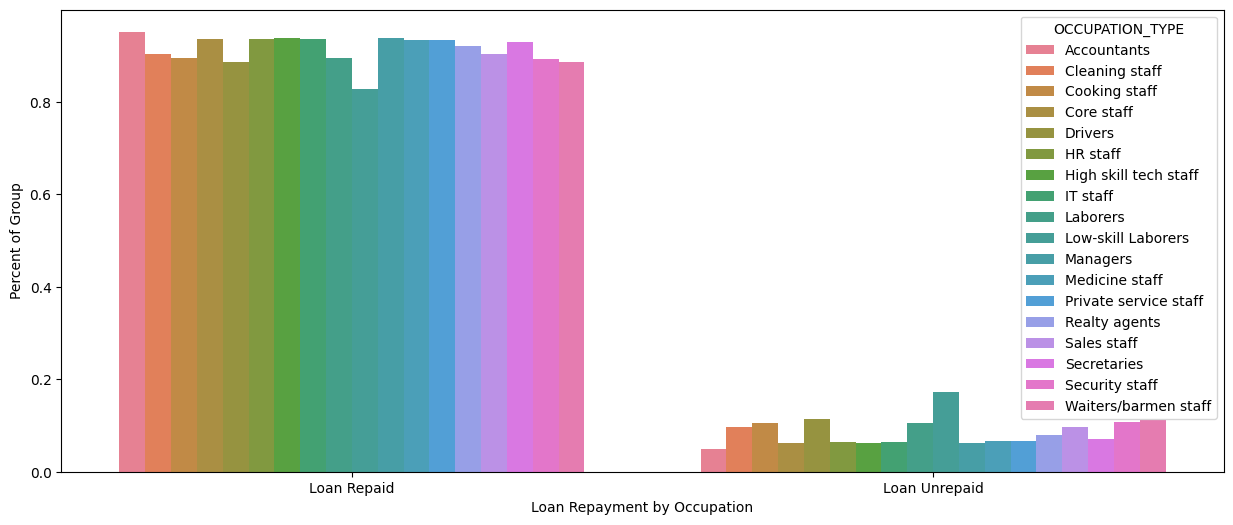

In [ ]:
hist_df = app_train_categorical.groupby(['OCCUPATION_TYPE','TARGET']).size().to_frame('count').reset_index()
new_col = app_train_categorical.groupby(['OCCUPATION_TYPE']).TARGET.value_counts(normalize=True).values
hist_df['frac'] = new_col
hist_df.replace({'TARGET': {0: 'Loan Repaid', 1.0: 'Loan Unrepaid'}}, inplace=True)
plt.figure(figsize = (15, 6))
sns.barplot(x='TARGET', y='frac', hue='OCCUPATION_TYPE', data=hist_df)
plt.ylabel('Percent of Group')
plt.xlabel('Loan Repayment by Occupation')
plt.show()

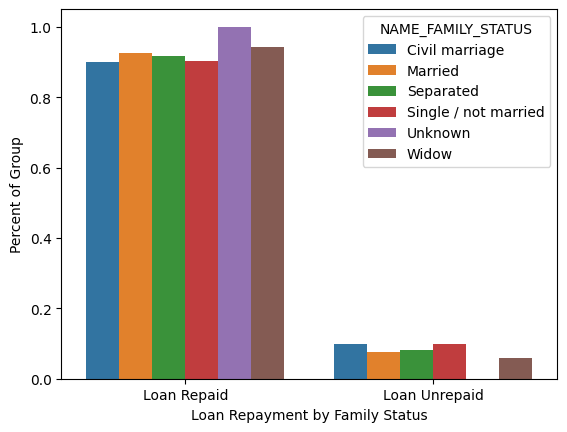

In [ ]:
hist_df = app_train_categorical.groupby(['NAME_FAMILY_STATUS','TARGET']).size().to_frame('count').reset_index()
new_col = app_train_categorical.groupby(['NAME_FAMILY_STATUS']).TARGET.value_counts(normalize=True).values
hist_df['frac'] = new_col
hist_df.replace({'TARGET': {0: 'Loan Repaid', 1.0: 'Loan Unrepaid'}}, inplace=True)
sns.barplot(x='TARGET', y='frac', hue='NAME_FAMILY_STATUS', data=hist_df)
plt.ylabel('Percent of Group')
plt.xlabel('Loan Repayment by Family Status')
plt.show()

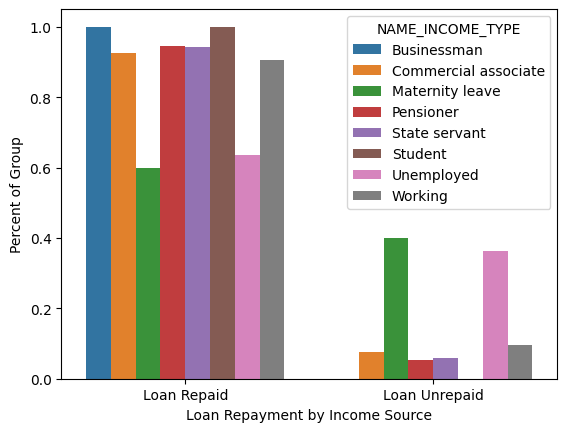

In [ ]:
hist_df = app_train_categorical.groupby(['NAME_INCOME_TYPE','TARGET']).size().to_frame('count').reset_index()
new_col = app_train_categorical.groupby(['NAME_INCOME_TYPE']).TARGET.value_counts(normalize=True).values
hist_df['frac'] = new_col
hist_df.replace({'TARGET': {0: 'Loan Repaid', 1.0: 'Loan Unrepaid'}}, inplace=True)
sns.barplot(x='TARGET', y='frac', hue='NAME_INCOME_TYPE', data=hist_df)
plt.ylabel('Percent of Group')
plt.xlabel('Loan Repayment by Income Source')
plt.show()

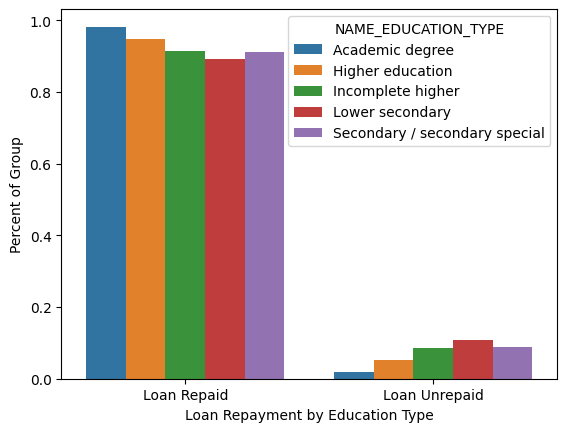

In [ ]:
hist_df = app_train_categorical.groupby(['NAME_EDUCATION_TYPE','TARGET']).size().to_frame('count').reset_index()
new_col = app_train_categorical.groupby(['NAME_EDUCATION_TYPE']).TARGET.value_counts(normalize=True).values
hist_df['frac'] = new_col
hist_df.replace({'TARGET': {0: 'Loan Repaid', 1.0: 'Loan Unrepaid'}}, inplace=True)
sns.barplot(x='TARGET', y='frac', hue='NAME_EDUCATION_TYPE', data=hist_df)
plt.ylabel('Percent of Group')
plt.xlabel('Loan Repayment by Education Type')
plt.show()

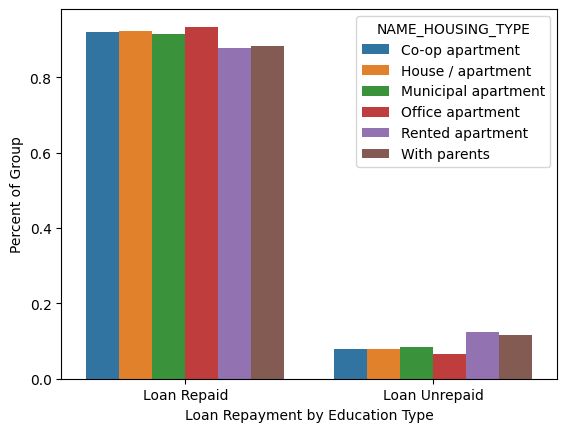

In [ ]:
hist_df = app_train_categorical.groupby(['NAME_HOUSING_TYPE','TARGET']).size().to_frame('count').reset_index()
new_col = app_train_categorical.groupby(['NAME_HOUSING_TYPE']).TARGET.value_counts(normalize=True).values
hist_df['frac'] = new_col
hist_df.replace({'TARGET': {0: 'Loan Repaid', 1.0: 'Loan Unrepaid'}}, inplace=True)
sns.barplot(x='TARGET', y='frac', hue='NAME_HOUSING_TYPE', data=hist_df)
plt.ylabel('Percent of Group')
plt.xlabel('Loan Repayment by Education Type')
plt.show()

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and below 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

### Pairwise Correlations

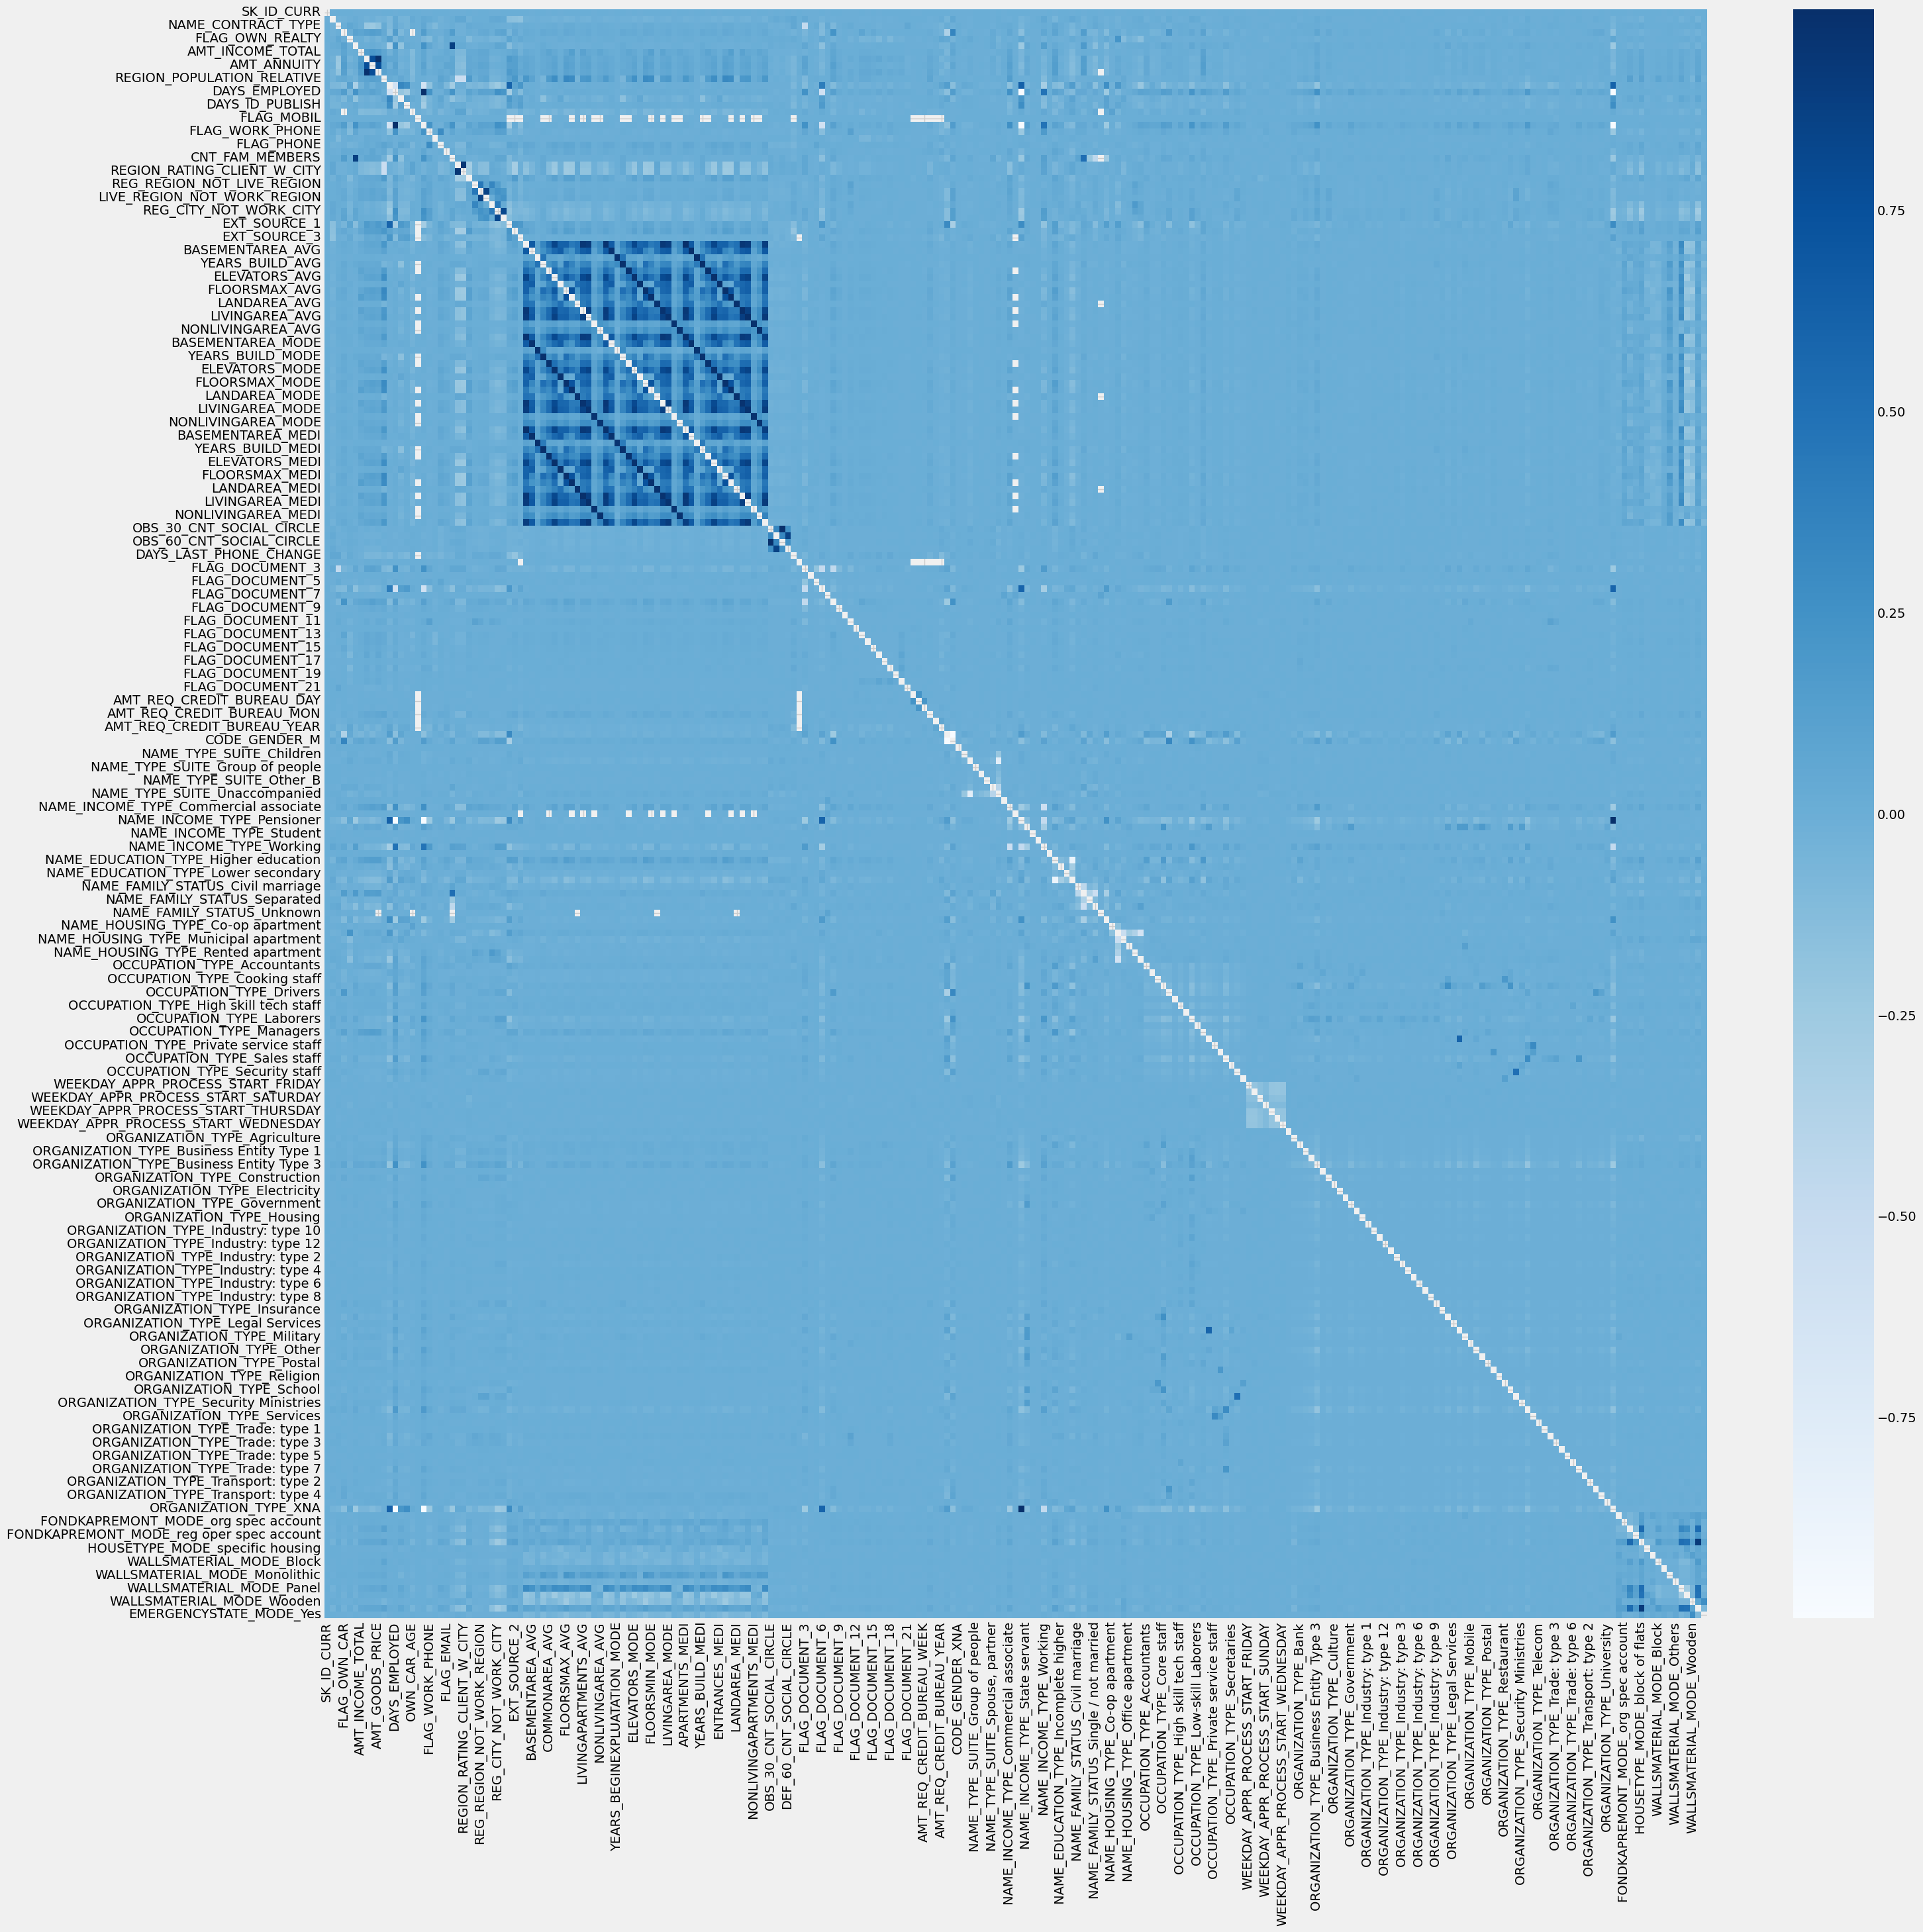

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(app_train.corr(), mask=np.identity(len(app_train.corr())), annot=False, cmap='Blues')
plt.show()

In [ ]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


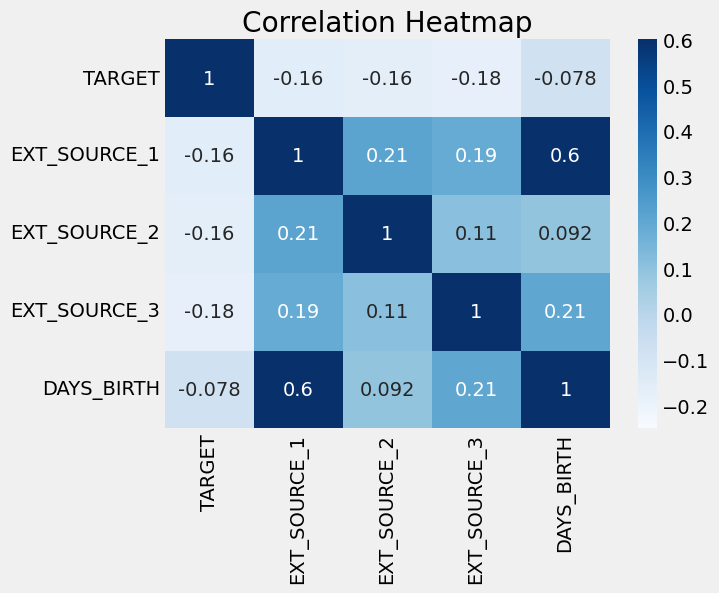

In [ ]:
sns.heatmap(ext_data_corrs, vmin=-0.25, vmax=0.6, annot=True, cmap='Blues')
plt.title('Correlation Heatmap')
plt.show()

# ADS / Model: Random Forest

## Random Forest Implementation

To get a baseline, we will use all of the features after encoding the categorical variables.

We will preprocess the data by filling in the missing values (imputation) and normalizing the range of the features (feature scaling).

In [ ]:
from sklearn.model_selection import train_test_split

target = app_train['TARGET']

# Drop the target from the training data
if 'TARGET' in app_train:
    app_train_new = app_train.copy().drop(columns = ['TARGET'])
else:
    app_train_new = app_train.copy()

# split 80/20
X_train, X_test, y_train, y_test = train_test_split(app_train_new, target, test_size=0.2, random_state=4)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Feature names
features = list(X_train.columns)

# Median imputation of missing values
imputer = SimpleImputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(X_train)

# Transform both training and testing data
train_new = imputer.transform(X_train)
test_new = imputer.transform(X_test)

# Repeat with the scaler
scaler.fit(imputer.transform(X_train))
# train = scaler.transform(train)
# test = scaler.transform(test)

train = pd.DataFrame(scaler.transform(scaler.transform(train_new)), columns=X_train.columns)
test = pd.DataFrame(scaler.transform(scaler.transform(test_new)), columns=X_test.columns)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (246008, 242)
Testing data shape:  (61503, 242)


In [ ]:
test_df = pd.DataFrame(test_new, columns=X_test.columns)

test_df.shape

(61503, 242)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Build model
random_forest = RandomForestClassifier(n_estimators=150, max_depth = 20, class_weight='balanced', random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
# Training
random_forest.fit(train, y_train)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})
sorted_feature_importances = feature_importances.sort_values(by='importance', ascending=False)

sorted_feature_importances

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.6min finished


,feature,importance
33,EXT_SOURCE_3,9.767571e-02
32,EXT_SOURCE_2,9.232006e-02
31,EXT_SOURCE_1,3.775295e-02
10,DAYS_BIRTH,3.607071e-02
13,DAYS_ID_PUBLISH,3.012253e-02
...,...,...
15,FLAG_MOBIL,1.637792e-21
135,NAME_FAMILY_STATUS_Unknown,0.000000e+00
118,NAME_INCOME_TYPE_Businessman,0.000000e+00
110,CODE_GENDER_XNA,0.000000e+00


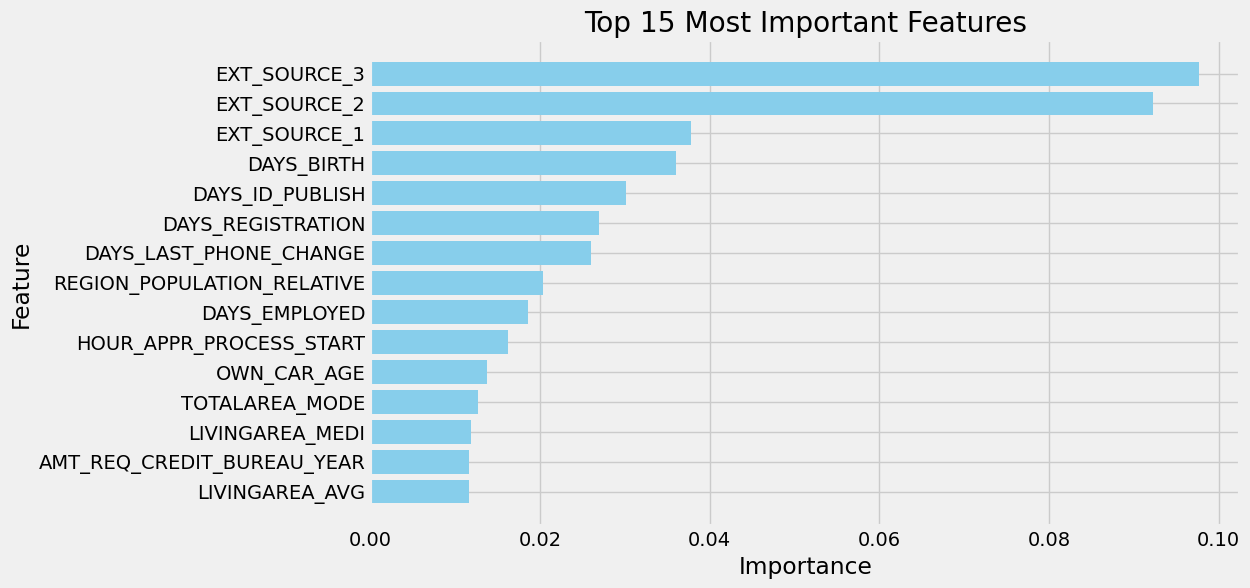

In [ ]:
# Plot the most important features, relative importance, actually how the model make decisions
top_features = sorted_feature_importances.head(15)
plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = random_forest.predict(test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.6s


Accuracy Score: 0.8487228265287872


[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:    4.6s finished


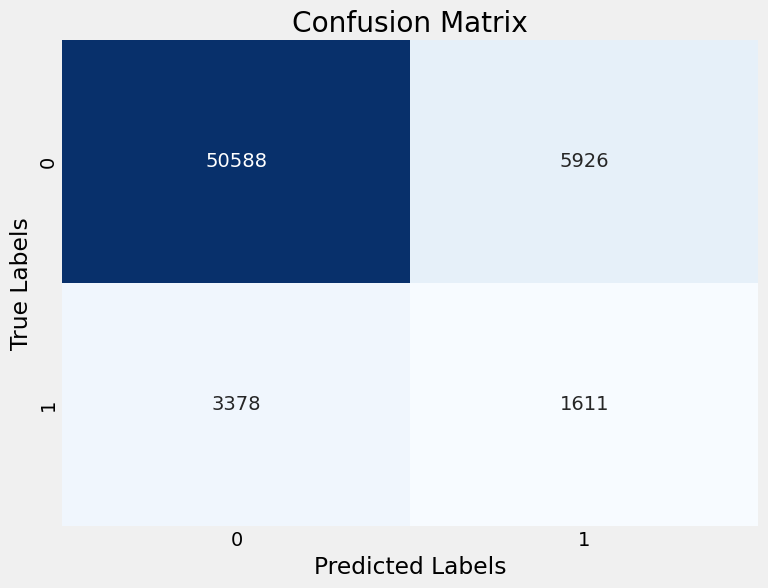

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Explain the Model - SHAP

In [ ]:
!pip install shap==0.43.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 6.4 MB/s eta 0:00:00


In [ ]:
import shap

n_rows = 1000
sample_explainer = shap.TreeExplainer(random_forest, train.iloc[:n_rows,:])
shap_values_sample = sample_explainer(train.iloc[:n_rows,:],check_additivity=False)

100%|===================| 1993/2000 [07:11<00:01]       

In [ ]:
explainer = shap.TreeExplainer(random_forest)

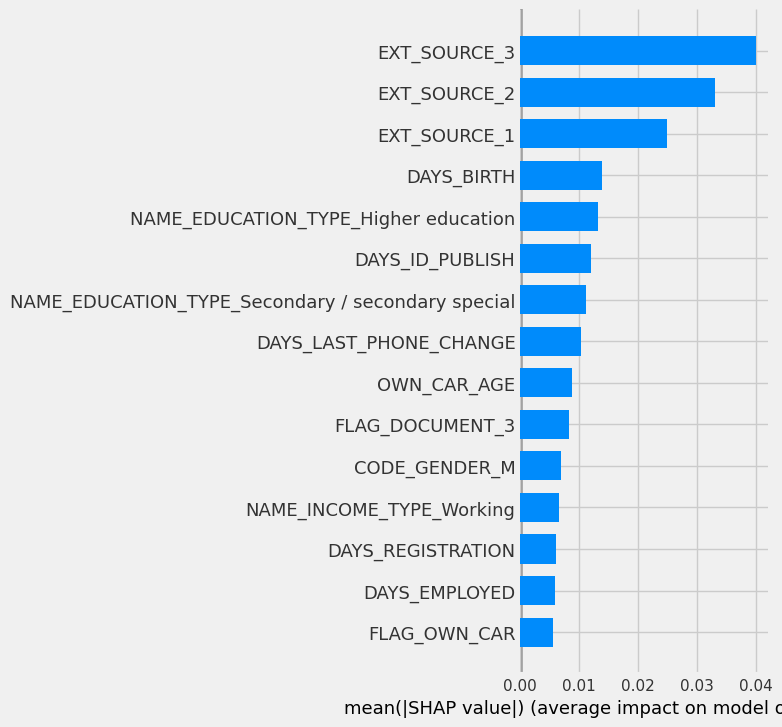

In [ ]:
shap.summary_plot(shap_values_sample[:,:,1], train.iloc[:,:], plot_type="bar",max_display=15, feature_names=features)
# Feature importance of random forest is more informative and accurate

In [ ]:
# Select 4 examples
import random
samples = []
id = 0

while len(samples) < 4:
    i = len(samples)
    if i == 0: # TP
        if y_test.iloc[id] == y_pred[id] and y_test.iloc[id] == 0:
            samples.append(id)
    if i == 1: # TN
        if y_test.iloc[id] == y_pred[id] and y_test.iloc[id] == 1:
            samples.append(id)
    if i == 2: # FN
        if y_test.iloc[id] != y_pred[id] and y_test.iloc[id] == 0:
            samples.append(id)
    if i == 3: # FP
        if y_test.iloc[id] != y_pred[id] and y_test.iloc[id] == 1:
            samples.append(id)
    id += 1

samples

[0, 16, 19, 62]

In [ ]:
class_names = ['Successfully Repaid', 'Not Repaid']

shap.initjs()
for id in samples:
    label = ""
    if (y_test.iloc[id] == y_pred[id]):
        label = "Correctly Classified"
    if (y_test.iloc[id] != y_pred[id]):
        label = "Misclassified"
    print(f'Document {str(id)} is {label}.')
    print(f'The actual value is {class_names[y_test.iloc[id]]} and predicted as {class_names[y_pred[id]]}')

    choosen_instance = test.iloc[[id]]
    shap_values_0 = explainer.shap_values(choosen_instance)
    shap.initjs()
    display(shap.force_plot(explainer.expected_value[1], shap_values_0[1], choosen_instance))

Document 0 is Correctly Classified.
The actual value is Successfully Repaid and predicted as Successfully Repaid


Document 16 is Correctly Classified.
The actual value is Not Repaid and predicted as Not Repaid


Document 19 is Misclassified.
The actual value is Successfully Repaid and predicted as Not Repaid


Document 62 is Misclassified.
The actual value is Not Repaid and predicted as Successfully Repaid


## Fairness Metrics

In [ ]:
!pip install fairlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 6.1 MB/s eta 0:00:00


In [ ]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, selection_rate
from fairlearn.metrics import false_negative_rate, false_positive_rate

In [ ]:
test_df

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,111929.0,0.0,1.0,0.0,1.0,157500.0,450000.0,16807.5,450000.0,0.028663,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,100580.0,0.0,0.0,1.0,0.0,270000.0,528318.0,26973.0,441000.0,0.007330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,142116.0,0.0,1.0,1.0,1.0,157500.0,91647.0,8532.0,76500.0,0.025164,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,228811.0,0.0,0.0,0.0,0.0,90000.0,225000.0,15219.0,225000.0,0.024610,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,181044.0,0.0,1.0,1.0,2.0,225000.0,284256.0,28111.5,270000.0,0.010006,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61498,399105.0,0.0,0.0,1.0,1.0,247500.0,900000.0,38263.5,900000.0,0.014520,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61499,333272.0,0.0,0.0,1.0,1.0,112500.0,904500.0,29178.0,904500.0,0.018209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
61500,455557.0,0.0,0.0,1.0,5.0,112500.0,896643.0,35689.5,724500.0,0.018801,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61501,329432.0,0.0,0.0,1.0,0.0,247500.0,1312110.0,55723.5,1125000.0,0.046220,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
for col in test.columns:
    print(col)

SK_ID_CURR
NAME_CONTRACT_TYPE
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
COMMONAREA_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_MODE
FLOORSMIN_MODE
LANDAREA_MODE
LIVIN

## Fairness - Age

In [ ]:
test_df['DAYS_BIRTH_Categorized'] = pd.cut(test_df['DAYS_BIRTH'], bins=[-float('inf'), 43, float('inf')], labels=[0, 1], right=False)

0        28.928767
1        52.076712
2        26.630137
3        27.032877
4        44.342466
           ...    
61498    45.857534
61499    37.405479
61500    56.838356
61501    43.035616
61502    33.369863
Name: DAYS_BIRTH, Length: 61503, dtype: float64

In [ ]:
age_demo_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features = pd.DataFrame(test_df)['DAYS_BIRTH_Categorized'])
age_demo_parity_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=pd.DataFrame(test_df)['DAYS_BIRTH_Categorized'])

print(f'Demographic parity difference (Sensitive feature = age): {age_demo_parity_diff:.4f}')
print(f'Demographic parity ratio (Sensitive feature = age): {age_demo_parity_ratio:.4f}')

# very imbalanced (compared to 0.8-1.2 optimal)

Demographic parity difference (Sensitive feature = age): 0.1254
Demographic parity ratio (Sensitive feature = age): 0.3257


In [ ]:
sensitive_feature_age = test_df['DAYS_BIRTH_Categorized'].replace({0:'young', 1:'old'})

#evaluation metrics
metrics = {'accuracy': accuracy_score,
           'selection_rate': selection_rate,
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_age = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_age)

grouped_on_age.overall

accuracy          0.848723
selection_rate    0.122547
FNR               0.677090
FPR               0.104859
dtype: float64

<Axes: title={'center': 'FNR and FPR by sex'}, xlabel='DAYS_BIRTH_Categorized'>

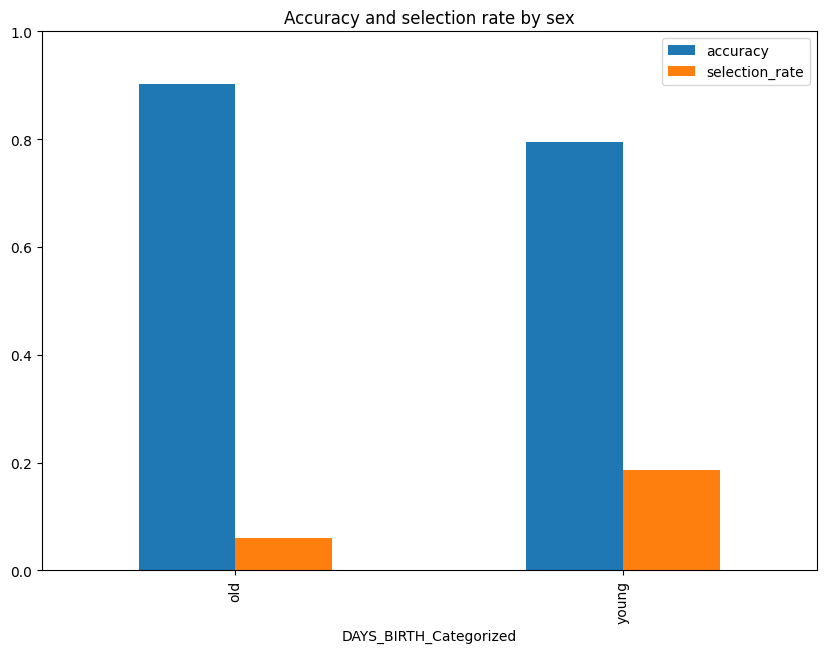

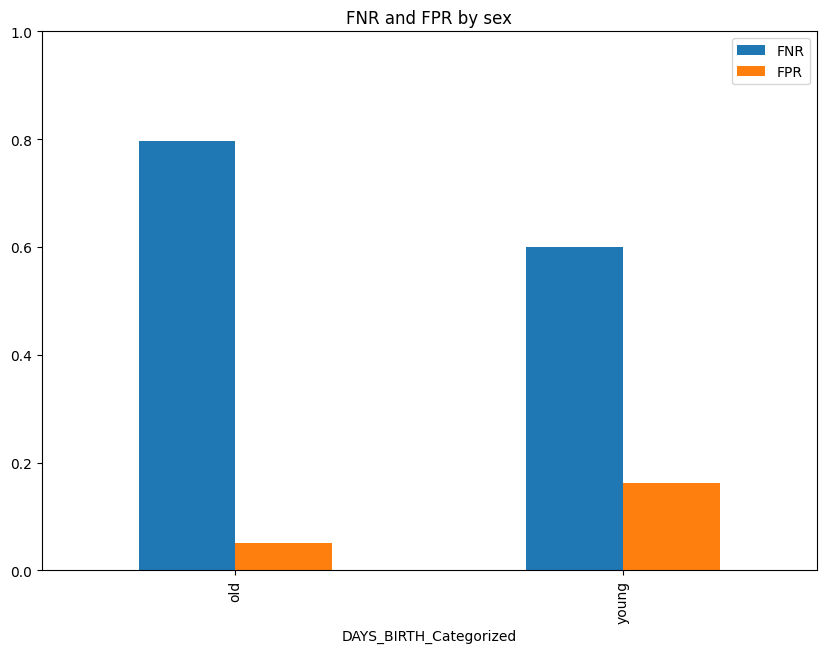

In [ ]:
metrics_1 = {'accuracy': accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           }

metrics_2 = {
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_age_accuracy_selection = MetricFrame(metrics=metrics_1,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_age)

grouped_on_age_fpr_fnr = MetricFrame(metrics=metrics_2,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_age)

grouped_on_age_accuracy_selection.by_group.plot.bar(
    subplots=False,
    figsize=(10, 7),
    ylim=[0,1],
    title="Accuracy and selection rate by Age",
    )

grouped_on_age_fpr_fnr.by_group.plot.bar(
    subplots=False,
    figsize=(10, 7),
    ylim=[0,1],
    title="FNR and FPR by Age",
    )

# which FNR or FPR is more important? which group is more dicriminative against?
# FPR ratio, FNR ratio (0.8-1.2 optimal rate)
# which metric we care the most, who is hurting and benefiting

## Fairness - Sex

In [ ]:
sex_demo_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features = pd.DataFrame(test_df)['CODE_GENDER_F'])
sex_demo_parity_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=pd.DataFrame(test_df)['CODE_GENDER_F'])

print(f'Demographic parity difference (Sensitive feature = sex): {sex_demo_parity_diff:.4f}')
print(f'Demographic parity ratio (Sensitive feature = sex): {sex_demo_parity_ratio:.4f}')

Demographic parity difference (Sensitive feature = sex): 0.0787
Demographic parity ratio (Sensitive feature = sex): 0.5484


In [ ]:
sensitive_feature_sex = test_df['CODE_GENDER_F'].astype(int).replace({1:'female', 0:'male'})

#evaluation metrics
metrics = {'accuracy': accuracy_score,
           'selection_rate': selection_rate,
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_sex = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_sex)

grouped_on_sex.overall

accuracy          0.848723
selection_rate    0.122547
FNR               0.677090
FPR               0.104859
dtype: float64

<Axes: title={'center': 'FNR and FPR by Sex'}, xlabel='CODE_GENDER_F'>

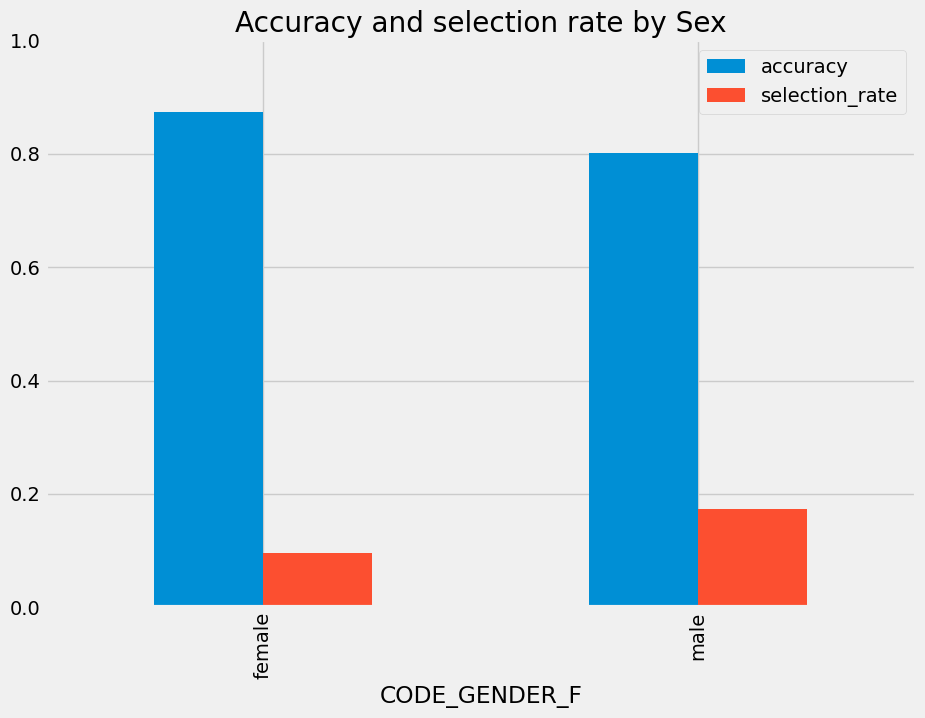

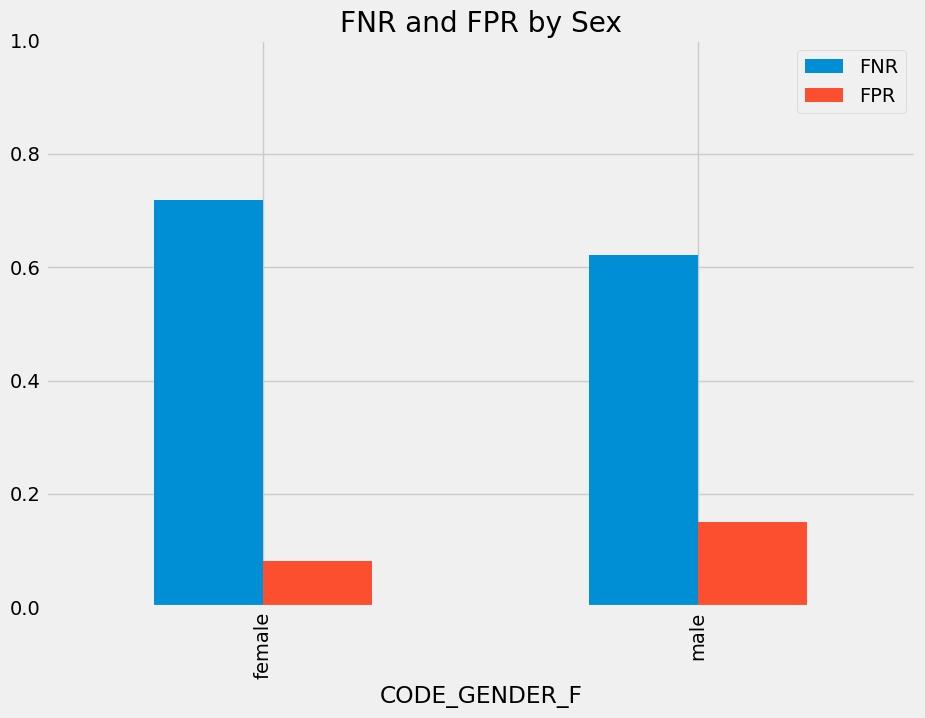

In [ ]:
metrics_1 = {'accuracy': accuracy_score,
           'selection_rate': selection_rate,  # i.e., the percentage of the population which have ‘1’ as their predicted label
           }

metrics_2 = {
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_sex_accuracy_selection = MetricFrame(metrics=metrics_1,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_sex)

grouped_on_sex_fpr_fnr = MetricFrame(metrics=metrics_2,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_sex)

grouped_on_sex_accuracy_selection.by_group.plot.bar(
    subplots=False,
    figsize=(10, 7),
    ylim=[0,1],
    title="Accuracy and selection rate by Sex",
    )

grouped_on_sex_fpr_fnr.by_group.plot.bar(
    subplots=False,
    figsize=(10, 7),
    ylim=[0,1],
    title="FNR and FPR by Sex",
    )

# which FNR or FPR is more important? which group is more dicriminative against?
# FPR ratio, FNR ratio (0.8-1.2 optimal rate)
# which metric we care the most, who is hurting and benefiting